In [9]:
from typing import List, TypedDict
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv

from langchain_ollama import ChatOllama

load_dotenv()

True

In [10]:
docs = (
    PyPDFLoader("./docs/book1.pdf").load() +
    PyPDFLoader("./docs/book2.pdf").load() +
    PyPDFLoader("./docs/book3.pdf").load()
)

In [11]:
chunks = RecursiveCharacterTextSplitter(chunk_size = 900, chunk_overlap = 150).split_documents(docs)

for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")


embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store  = FAISS.from_documents(chunks, embeddings)

retriver = vector_store.as_retriever(search_type="similarity" , search_kwargs = {'k':4})

llm = init_chat_model("gpt-4o")
filter_llm = ChatOllama(
    model="llama3.2:3b",  # Fast, good for filtering
    temperature=0,
    format="json"  # Forces JSON output
)


In [12]:
class State(TypedDict):
    question: str
    docs: List[Document]

    strips: List[str]  #output of decomposition (sentence strip)
    kept_strips: List[str] # after filtering (kept sentences)
    refined_context: str #recomposed internal knowledge (joined kept_strips)
    
    answer: str

In [13]:
def retreive(state):
    q = state["question"]
    return {
        "docs" : retriver.invoke(q)
    }

import re

def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)

    return [
        s.strip() for s in sentences if len(s.strip()) > 20
    ]

from pydantic import BaseModel

class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        "You are a strict relevance filter.\n"
        "Return keep=true only if the sentence direclty helps answer the question.\n"
        "Use Only the sentence. Output JSON only.\n"
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}")
    ]
)

filter_chain = filter_prompt | filter_llm.with_structured_output(KeepOrDrop)


def refine(state: State) -> State:
    q = state["question"]

    # combine retrieved docs into one context string
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()

    # 1. decomposition (context -> sentence strips)
    strips = decompose_to_sentences(context)

    # 2 filter: Keep only relvant strips
    kept: List[str] = []

    for s in strips:
        if filter_chain.invoke({"question": q, "sentence":s}).keep:
            kept.append(s)
    
    # 3 RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context" : refined_context
    }


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer from the context provided,"),
        ("human", "Question: {question}\n\n Context:\n{context}"),
    ]
)

def generate(state):
    context = "\n\n".join(d.page_content for d in state["docs"])
    out = (prompt | llm).invoke({
        "question": state["question"], "context": context
    })

    return {
        "answer": out.content
    }

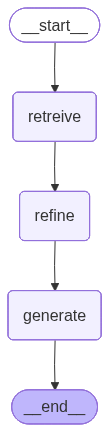

In [14]:
g = StateGraph(State)

g.add_node("retreive", retreive)
g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retreive")
g.add_edge("retreive", "refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()
app

In [15]:
res = app.invoke({
    "question": "Explain the bias-variance tradeoff"
})

print(res["answer"])

The bias-variance tradeoff is a fundamental concept in statistics and machine learning that addresses the tradeoff between a model's ability to generalize to new data and its capacity to accurately fit the training data.

1. **Bias**: Bias refers to the error due to overly simplistic assumptions in the learning algorithm. For example, assuming that the relationship between features and output is linear when it could be more complex. A high-bias model typically leads to underfitting, which means it doesn't capture the underlying trend of the data well.

2. **Variance**: Variance refers to the error due to the model's sensitivity to fluctuations in the training data. A model with high variance pays too much attention to the training data and captures noise along with the underlying patterns, leading to overfitting.

3. **Irreducible Error**: This part of the generalization error arises from the inherent randomness in the data. It is unrelated to the model and cannot be reduced by modifyi